# Laboratory #4_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB 
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq
from skimage import color, data, exposure, feature, filters, io, transform 
from matplotlib import pyplot as plt
import skimage
from skimage import io


from sklearn.cluster import MiniBatchKMeans
import time

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [3]:
# modify the dataset variable with the path from your drive
dataset_path = r'/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB8/p4_2_image_classification_using_BoVW/101_ObjectCategories'

In [4]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [5]:
# solution
labels = os.listdir(dataset_path)
file_list = []
label_list = []
for label in categories:
  images_path=f'{dataset_path}/{label}'
  images=os.listdir(images_path)
  file_list += [label + '/' + image_name for image_name in images]
  label_list += [label for image_name in images]

In [6]:
print('Total number of images:', len(file_list))
print(file_list)

Total number of images: 244
['butterfly/image_0026.jpg', 'butterfly/image_0025.jpg', 'butterfly/image_0013.jpg', 'butterfly/image_0023.jpg', 'butterfly/image_0020.jpg', 'butterfly/image_0004.jpg', 'butterfly/image_0006.jpg', 'butterfly/image_0018.jpg', 'butterfly/image_0007.jpg', 'butterfly/image_0005.jpg', 'butterfly/image_0008.jpg', 'butterfly/image_0014.jpg', 'butterfly/image_0010.jpg', 'butterfly/image_0024.jpg', 'butterfly/image_0011.jpg', 'butterfly/image_0022.jpg', 'butterfly/image_0019.jpg', 'butterfly/image_0017.jpg', 'butterfly/image_0012.jpg', 'butterfly/image_0016.jpg', 'butterfly/image_0067.jpg', 'butterfly/image_0046.jpg', 'butterfly/image_0048.jpg', 'butterfly/image_0072.jpg', 'butterfly/image_0041.jpg', 'butterfly/image_0068.jpg', 'butterfly/image_0062.jpg', 'butterfly/image_0034.jpg', 'butterfly/image_0089.jpg', 'butterfly/image_0070.jpg', 'butterfly/image_0059.jpg', 'butterfly/image_0071.jpg', 'butterfly/image_0029.jpg', 'butterfly/image_0084.jpg', 'butterfly/image_00

*   Create a train / test split where the test is 10% of the total data

In [7]:
# solution
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(file_list, shuffle=True, test_size=0.1, random_state=42)

labels_train = []
for i in range(len(x_train)):
  labels_train.append(x_train[i].split('/')[0])

labels_test = []
for i in range(len(x_test)):
  labels_test.append(x_test[i].split('/')[0])

In [8]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


*   How do you select the train/test split?

**Solution**

*Using the **train_test_split** function to shuffle the dataset and split it randomly.*

...

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 256 keypoints.


In [9]:
# solution
n_kp = 256
descriptor_extractor = ORB(n_keypoints=n_kp)

*   Extract ORB descriptors from all the images in the train set.


In [10]:
# solution
kp_all_ORB = []
desc_all_ORB = []
t0 = time.time()

for i in range(len(x_train)):

  # Read the image and put in grayscale
  d = (dataset_path+'/'+x_train[i])
  img = io.imread(d)
  img = rgb2gray(img)
  # We extract the descriptor and the key points from the img
  descriptor_extractor.detect_and_extract(img)
  keypoints = descriptor_extractor.keypoints
  descriptors = descriptor_extractor.descriptors
  # Save the descriptors and keypoints in an global matrix
  kp_all_ORB.append(keypoints)
  desc_all_ORB.append(descriptors)

dt = time.time() - t0
print("done in %.2fs." % dt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  # This is added back by InteractiveShellApp.init_path()


done in 261.86s.


*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [11]:
# solution
print(f'Descriptors generate with exit, the size of the descriptors is {len(desc_all_ORB)}')  
print(np.array(desc_all_ORB).shape)
print(f'Key points generate with exit, the size of this is {len(kp_all_ORB)}')  
print(np.array(kp_all_ORB).shape)

Descriptors generate with exit, the size of the descriptors is 219
(219, 256, 256)
Key points generate with exit, the size of this is 219
(219, 256, 2)


**Solution**

*For each image in the dataset, we look for 256 keypoints, each of which has an associated descriptor to it. The ORB detector uses binary descriptors, that is, vectors of Boolean type which in our case are of length 256.*

*Because there are 256 keypoints per image and we are taking 219 images for the train set, the size of the variable ('desc_all_ORB') that contains all of the descriptors is then: (219, 256, 256).*

...

### Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [12]:
# Reshape the dataset to have a list with all the descriptors (n_descriptors = n_images x n_keypoints)
X = desc_all_ORB[0]
for i in range(1,len(x_train)):
  X = np.vstack((X,desc_all_ORB[i]))
# Convert list to array
X = np.array(X)
X.shape

(56064, 256)

In [13]:
# solution
from sklearn.feature_extraction.image import extract_patches_2d

K = 3*10
kmeans = MiniBatchKMeans(n_clusters=K)#,random_state=0,batch_size=6,max_iter=10)
kmeans.fit(X)
codebook = kmeans.cluster_centers_

In [14]:
np.array(codebook).shape
# Each cluster center produced by k-means becomes a codevector, so we have 30 codevectors
# If we compare the codebook to a dictionary, each codevector represents one "word" in our Bag of Words

(30, 256)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [15]:
# 1. Visual histograms (one per image in the training-set)
import matplotlib.pyplot as plt

Y = kmeans.predict(X)

histogram, ax = plt.subplots(1,len(x_train),figsize=(300,2))
for i in range(len(x_train)):
  ax[i].hist(Y[i*n_kp:(i+1)*n_kp], bins = K, color='magenta')
  # ax[i].axes.xaxis.set_visible(False)
  # ax[i].axes.yaxis.set_visible(False)
  ax[i].set_ylim([0, n_kp])
  ax[i].set_title("Fig. "+str(i+1))

for ax in histogram.get_axes():
    ax.label_outer()
plt.show()

# Representation of the images in the training set
images, axis = plt.subplots(1,len(x_train),figsize=(300,2))
for i in range(len(x_train)):
  d = (dataset_path+'/'+x_train[i])
  img = io.imread(d)
  axis[i].imshow(img)
  axis[i].axes.xaxis.set_visible(False)
  axis[i].axes.yaxis.set_visible(False)
  axis[i].set_title("Fig. "+str(i+1))
plt.show()

# NOTE: Click on the generated figures to englargen them

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# 2. Histogram matrix (219 images x 30 clusters)
histMatrix = np.zeros((len(x_train),K),"int32")
for i in range(len(x_train)):
  for j in range(n_kp):
    for k in range(K):
      if Y[i*n_kp+j]==k+1:
        histMatrix[i,k]+=1

from sklearn.preprocessing import StandardScaler
histMatrix = StandardScaler().fit_transform(histMatrix) # normalize the histogram matrix


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [18]:
# solution
c_model = SVC(kernel = 'rbf')
param_grid = {'C':np.logspace(-3,3,50), 'gamma':np.logspace(-4,1,50)}

#param_grid = {'C': [1, 10, 100, 1000, 10000], 'gamma': [0.001, 0.0001, 0.00001]}
classModel = GridSearchCV(c_model, param_grid)
classModel.fit(histMatrix,labels_train) # The training-set has 219 figures, with 30 features each

print("Best parameters set found by GridSearchCV:")
print()
print(classModel.best_params_)

Best parameters set found by GridSearchCV:

{'C': 79.06043210907701, 'gamma': 0.0006551285568595509}


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [24]:
# solution

# 1. Extract descriptors for the test-set (25 images, 256 descriptors per image):
desc_all_ORB_test = []
for i in range(len(x_test)):
  # Read the image and put in grayscale
  d = (dataset_path+'/'+x_test[i])
  img = io.imread(d)
  img = rgb2gray(img)
  # We extract the descriptors from the img
  descriptor_extractor.detect_and_extract(img)
  descriptors = descriptor_extractor.descriptors
  # Save the descriptors in an global matrix
  desc_all_ORB_test.append(descriptors)

# 2. Generate their histograms (25 images x 30 clusters):
histMatrix_test = np.zeros((len(x_test),K),"int32")
for i in range(len(x_test)):
  for j in range(n_kp):
    for k in range(K):
      if Y[i*n_kp+j]==k+1:
        histMatrix_test[i,k]+=1
histMatrix_test = StandardScaler().fit_transform(histMatrix_test) # normalize the histogram matrix

# 3. Use the SVC model to predict their labels
labels_test_pred = classModel.predict(histMatrix_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


*   Calculate the accuracy score for the classification model

In [25]:
# solution
from sklearn.metrics import accuracy_score
print('Accuracy of the classification model is:')
print(accuracy_score(labels_test, labels_test_pred))

Accuracy of the classification model is:
0.28


*   Generate the confusion matrix for the classification model

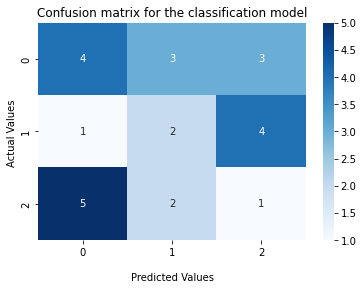

In [27]:
# solution
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay 
import seaborn as sns

# confusion matrix

ConfusionMatrix = confusion_matrix(labels_test, labels_test_pred)
ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the classification model');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

*Clustering is used to create the codebook so that the descriptors that are very similar among each other can be considered as a single "visual-word", instead of having many individual "words" that have almos the same meaning (meaning they represent very similar features of the image). By Clustering, we are able to group those visual features that are very close to each other in their own cluster, and approximate them by the center of said cluster.*

*For the generation of the codebook other techniques such as the Gaussian Mixture Model can be used too.*

...

*   Will adding more keypoints increase the performanc of the algorithm?

**Solution**
The number of key points doesn't help a lot for the classification task
* 256 Keypoints --> Accuracy of the classification model is: 0.32*
* 300 Keypoints --> Accuracy of the classification model is: 0.33*
* 200 Keypoints --> Accuracy of the classification model is: 0.28*


...

# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

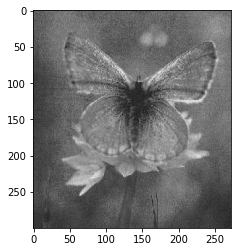

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

path_dp = '/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB8/p4_2_image_classification_using_BoVW/101_ObjectCategories/'
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

for category in categories:
  path = os.path.join(path_dp,category)  #Path to images in categories
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break
  break  


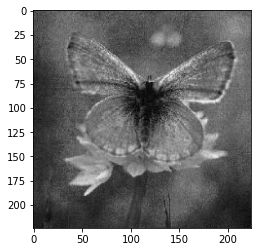

In [29]:
#Resize the images for (224,224)
img_size = 224
img_dataset = cv2.resize(img_array,(img_size,img_size))
plt.imshow(img_dataset,cmap = 'gray')
plt.show()

In [45]:
import random
from sklearn.model_selection import train_test_split

#Function to load and create the dataset

dataset_img_nn = []
img_size = 224
def create_dataset():
    for category in categories:
        path = os.path.join(path_dp,category)  #Path to images in categories
        #categories = ['butterfly'=0 , 'kangaroo'= 1, 'dalmatian' = 2]
        class_num = categories.index(category)
        for img in os.listdir(path):
          try:
            img_array = cv2.imread(os.path.join(path,img))
            img_dataset = cv2.resize(img_array,(img_size,img_size))
            dataset_img_nn.append([img_dataset,class_num])
          except Exception as e:
            pass  
    # Shuffle the dataset
    random.shuffle(dataset_img_nn)         

create_dataset()

x_nn = []
y_nn = []
for features, label in dataset_img_nn:
  x_nn.append(features)
  y_nn.append(label)



x_nn = np.array(x_nn).reshape(-1,img_size,img_size,3).astype('float32')/255
y_nn = np.array(y_nn).astype('float32')
print(f'The dimension of the dataset is : {x_nn.shape}') 


x_train_nn, x_test_nn, x_label_train_nn, x_label_test_nn = train_test_split(x_nn,y_nn, test_size=0.1)

print(x_train_nn.shape)
print(x_test_nn.shape)
print(x_label_train_nn.shape)
print(x_label_test_nn.shape)

The dimension of the dataset is : (244, 224, 224, 3)
(219, 224, 224, 3)
(25, 224, 224, 3)
(219,)
(25,)


## Load ResNet50 model with imagenet weights and check the summary of the model

In [46]:
# Load ResNet50 model with imagenet weights and check the summary of the model
import tensorflow as tf
import keras

# Create a model to extract features from the 'avg_pool' layer
model_Resnet = tf.keras.applications.ResNet50(
    weights = "imagenet", #Load weights pre-trained on ImageNet
    input_shape =(224,224,3),
    include_top = False,
)# Do not include the ImageNet classifier at the top.


model_Resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [47]:
# Extract features from the layer for all the train images:
extracted_features = model_Resnet.predict(x_train_nn)

*   What is the size of the feature descriptors?

In [48]:
# solution

print('Shape of the features as extracted from the network:')
print(extracted_features.shape)
features = extracted_features.reshape(extracted_features.shape[0]*extracted_features.shape[1]*extracted_features.shape[2],extracted_features.shape[3])
print('Number of descriptors per image:')
n_descriptors_nn = features.shape[0]//len(x_train)
print(n_descriptors_nn)
print('Size of each descriptor:')
print(features.shape[1])

Shape of the features as extracted from the network:
(219, 7, 7, 2048)
Number of descriptors per image:
49
Size of each descriptor:
2048


*   Create codebook using the extracted features

In [49]:
# solution
from sklearn.feature_extraction.image import extract_patches_2d

K = 3*10
kmeans_nn = MiniBatchKMeans(n_clusters=K,random_state=0,batch_size=6,max_iter=10)
kmeans_nn.fit(features)
codebook_nn = kmeans_nn.cluster_centers_
np.array(codebook_nn).shape


# 2. Histogram matrix (219 images x 30 clusters)
Y_nn = kmeans_nn.predict(features)

histMatrix_train_nn = np.zeros((len(x_train),K),"int32")
for i in range(len(x_train)):
  for j in range(n_descriptors_nn):
    for k in range(K):
      if Y_nn[i*n_descriptors_nn+j]==k+1:
        histMatrix_train_nn[i,k]+=1

from sklearn.preprocessing import StandardScaler
histMatrix_train_nn = StandardScaler().fit_transform(histMatrix_train_nn) # normalize the histogram matrix
print(histMatrix_train_nn.shape)
print(x_label_train_nn.shape)



(219, 30)
(219,)


*   Train SVM classifier using the codebook

In [50]:
# solution
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Y_features = kmeans_nn.predict(features)

c_model_nn = SVC(kernel = 'rbf')
param_grid_nn = {'C':np.logspace(-3,4,18), 'gamma':np.logspace(-3,2,18)}

#param_grid = {'C': [1, 10, 100, 1000, 10000], 'gamma': [0.001, 0.0001, 0.00001]}
classModel_nn = GridSearchCV(c_model_nn, param_grid_nn)
classModel_nn.fit(histMatrix_train_nn,x_label_train_nn) # The training-set has 219 figures, with 30 features each

print("Best parameters set found by GridSearchCV:")
print()
print(classModel_nn.best_params_)

Best parameters set found by GridSearchCV:

{'C': 33.83855153428233, 'gamma': 0.015013107289081735}


*   Evaluate the test set using the above method

In [51]:
# solution

#Extract features from test dataset:
extracted_features_test = model_Resnet.predict(x_test_nn)
features_test = extracted_features_test.reshape(extracted_features_test.shape[0]*extracted_features_test.shape[1]*extracted_features_test.shape[2],extracted_features_test.shape[3])

In [52]:
#Histogram matrix of the extracted features from the test set:
Y_test_nn = kmeans_nn.predict(features_test)

histMatrix_test_nn = np.zeros((len(x_test),K),"int32")
for i in range(len(x_test)):
  for j in range(n_descriptors_nn):
    for k in range(K):
      if Y_test_nn[i*n_descriptors_nn+j]==k+1:
        histMatrix_test_nn[i,k]+=1

from sklearn.preprocessing import StandardScaler
histMatrix_test_nn = StandardScaler().fit_transform(histMatrix_test_nn) # normalize the histogram matrix
print(histMatrix_test_nn.shape)
print(x_label_test_nn.shape)

(25, 30)
(25,)


In [53]:
#Use the SVC model to predict the labels of the test set:
labels_test_pred_nn = classModel_nn.predict(histMatrix_test)

*   Calculate the accuracy score and confusion matrix for the classification model

In [54]:
# solution

from sklearn.metrics import accuracy_score
print('Accuracy of the classification model is:')
print(accuracy_score(x_label_test_nn, labels_test_pred_nn))

Accuracy of the classification model is:
0.4


*   Compare the performance of both the BoVW models. Which model works better and why?

**Solution**

*I can indentify a mistake in a few figures in dataset and for that reason the accuracy in my models was affected. Aparently, when we charge the resnet50 and I used to extract the features of the images, the model seemed to have slightly better accuracy. However, because of the unability to read properly the whole dataset, these accuracy measurements are not enough to infer a conclusion and it would be necessary to fix said problems with the reading of the dataset. *

...

*   Can the performance of pre-trained model increased further? If so, how?

**Solution**

*We can improve more this kind of pre-trained model if we adapt it for our specific problem, that is known as Transfer learning. Here, we can add another layers to classify, also is neccesary to freeze the pre-trained layer and only train the layer that we put on top. *

...

*   What happens if the test image does not belong to any of the trained classes?

**Solution**

*Probably the models will try to assign the class that is the "best fit" for it, selecting among the available classes in the training set. Therefore, it would not be possible to classify it correctly with our model if it hasn't seen this new class before.*

...

*   Combine the features extracted using ORB and Deep Neural Network.
*   Create a codebook with the combined features
*   Train a SVM classifier using the generated codebook and evaluate the performance using accuracy and confusion matrix.

In [ ]:
# solution
tures_train_orb = np.array(descrip_lst)
features_train_nn = np.array(all_features_train)



features_test_orb = np.array(test_desc)
features_test_nn = np.array(all_test_features_nn)



*   Do the combined features increase the performance of the classifier?

**Solution**

*(Double-click or enter to edit)*

...

## t-distributed Stochastic Neighbor Embedding (Optional).

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(dictionary) 

plt.figure(figsize=(20,10))
plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=y_train)
plt.title("TSNE visualization")
plt.show()

NameError: ignored

*   What do you infer from the t-SNE plot?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P4_2: Image Classification using Bag of Visual Words**
Deadline for P4_2 submission in CampusVirtual is: **Monday, the 6th of December, 2021**

## Transfer learning

In [55]:
## Transfer learning
from keras.models import load_model
from keras.layers import Lambda
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

# solution  Load ResNet50 model with imagenet weights and check the summary of the model

base_model = tf.keras.applications.ResNet50(
    weights = "imagenet", #Load weights pre-trained on ImageNet
    input_shape =(224,224,3),
    include_top = False,
)# Do not include the ImageNet classifier at the top.

base_model.trainable = False      # First we freeze the model

# Create new model on top
#inputs = keras.Input(shape=(224, 224, 3))

# add a global spatial average pooling layer

x = base_model.output


# Create a model to extract features from the 'avg_pool' layer.
#x = keras.layers.GlobalAveragePooling2D()(x) #Extra
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)


x = Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()







model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)
epochs = 10




model.fit(x_nn,y_nn,batch_size=32, epochs = epochs,validation_split=0.1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


7/7 [==============================] - 37s 5s/step - loss: 0.7149 - binary_accuracy: 0.3425 - val_loss: 0.8331 - val_binary_accuracy: 0.4400
Epoch 2/10
7/7 [==============================] - 33s 5s/step - loss: 0.2794 - binary_accuracy: 0.3425 - val_loss: 0.1636 - val_binary_accuracy: 0.4400
Epoch 3/10
7/7 [==============================] - 33s 5s/step - loss: -0.1546 - binary_accuracy: 0.3699 - val_loss: -0.2243 - val_binary_accuracy: 0.6000
Epoch 4/10
7/7 [==============================] - 33s 5s/step - loss: -0.3036 - binary_accuracy: 0.3836 - val_loss: -0.3995 - val_binary_accuracy: 0.4400
Epoch 5/10
7/7 [==============================] - 33s 5s/step - loss: -0.5298 - binary_accuracy: 0.3653 - val_loss: -0.7016 - val_binary_accuracy: 0.4800
Epoch 6/10
7/7 [==============================] - 33s 5s/step - loss: -0.7555 - binary_accuracy: 0.3607 - val_loss: -0.9812 - val_binary_accuracy: 0.6000
Epoch 7/10
7/7 [==============================] - 33s 5s/step - loss: -0.9581 - binary_accu